# Point Cloud Binary Classification with PyTorch

Make sure you are using the `dl4cv` conda environment.

## Dataset loading and visualization

The input X contain 100 2D points, and y are their corresponding labels (0 or 1). The goal is to train a model that can classify every point to its correct label.


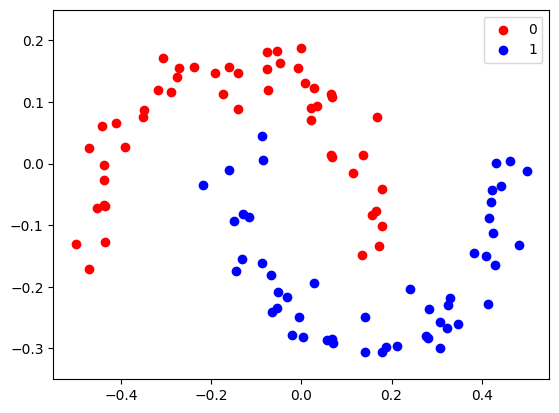

<Figure size 640x480 with 0 Axes>

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam

dataset = np.load('./2d_pcl_dataset.npz')
X, y = dataset['X'], dataset['y']

X0 = X[y==0] # 50 2D points have label 0
X1 = X[y==1] # 50 2D points have label 1

def plot(X0, X1, fit_param=None):
    plt.scatter(X0[:,0], X0[:,1], color='red', label=0)
    plt.scatter(X1[:,0], X1[:,1], color='blue', label=1)

    plt.xlim([-0.55, 0.55])
    plt.ylim([-0.35, 0.25])
    plt.legend()
    plt.show()
    plt.clf()

plot(X0, X1)

## Logistic Regression for the point cloud classification task


Starting by filling in the `Simple2DDataset` class below. First, in the class constructore `__init__`, you will need to read the right `2d_pcl_dataset.npz` from disk.

Second, in the `__getitem__`, you will need to take a single data point and its label based on its index `idx`

In [25]:
class Simple2DDataset(Dataset):
    def __init__(self):
        super().__init__()
        #########################################################################
        # TODO: read data from disk using np.load.
        # Data is located in the folder "data".
        # Save samples and labels to class members self.X and self.y respectively.
        # samples should be an Nx2 numpy array. Labels should be Nx1.
        #########################################################################
        self.X = 0
        self.y = 0
        dataset = np.load('./2d_pcl_dataset.npz')
        self.X, self.y = dataset['X'], dataset['y']

    def __len__(self):
        # Returns the number of samples in the dataset.
        return self.X.shape[0]

    def __getitem__(self, idx):
        #########################################################################
        # TODO: return the sample and label with index idx
        #########################################################################
        point = self.X[idx]
        label = self.y[idx]

        # Convert to tensor.
        return torch.from_numpy(point).float(), \
               torch.from_numpy(label[np.newaxis]).float()


With the complete `Simple2DDataset`, we can create a PyTorch dataloader

**NOTE**: if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`

In [26]:
BATCH_SIZE = 8
NUM_WORKERS = 4

# create the dataloader
dataset = Simple2DDataset()
train_dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Now, define your first network by filling in the `LinearClassifier` class below.

Add a single linear layer `nn.Linear` inside the `nn.Sequential` call. The input is 2D, and the output should be a single value, corresponding to the probability of a given 2D point being part of cluster 0.

In [27]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.codename = 'linear'

        #########################################################################
        # TODO: add a single linear layer with nn.Linear, inside the `nn.Sequential` call.
        # Input is 2D.
        # Output is a single value.
        #########################################################################
        self.model = nn.Sequential(
            nn.Linear(in_features=2, out_features=1)
        )

    def forward(self, batch):
        # Process batch using the defined model.
        x = self.model(batch)
        # Final sigmoid activation to obtain a probability between 0 and 1.
        return torch.sigmoid(x)

Now, you are asked to implement the training loop below

In [36]:
def train(net, optimizer, dataloader, epoch):
    net.train()
    loss_sum = 0
    for batch_idx, (point, label) in enumerate(dataloader):
        # First we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()

        #########################################################################
        #TODO:
        # 1. forward pass of the network to obtain the predictions given the batch
        # 2. compute the loss using F.binary_cross_entropy
        # 3. backward pass on the loss using loss.backward(), and one step
        # of gradient descent (optimization) using optimizer.step()
        #########################################################################
        y_pred = net(point)
        loss = F.binary_cross_entropy(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    return loss_sum


You can now run below to train the linear model.

In [37]:
NUM_EPOCHS = 100
# create the network.
net = LinearClassifier()

# create the optimizer.
optimizer = Adam(net.parameters(), lr=0.1)

best_accuracy = 0
for epoch_idx in range(NUM_EPOCHS):
    loss = train(net, optimizer, train_dataloader, epoch_idx)
    print('[Epoch %02d] Loss: %.4f' % (epoch_idx + 1, loss))

[Epoch 01] Loss: 7.9183
[Epoch 02] Loss: 6.3773
[Epoch 03] Loss: 5.7783
[Epoch 04] Loss: 5.1262
[Epoch 05] Loss: 4.9214
[Epoch 06] Loss: 4.7644
[Epoch 07] Loss: 4.5685
[Epoch 08] Loss: 4.1690
[Epoch 09] Loss: 4.3242
[Epoch 10] Loss: 4.2405
[Epoch 11] Loss: 3.8986
[Epoch 12] Loss: 3.9583
[Epoch 13] Loss: 3.9657
[Epoch 14] Loss: 3.9210
[Epoch 15] Loss: 3.7820
[Epoch 16] Loss: 3.8072
[Epoch 17] Loss: 3.8754
[Epoch 18] Loss: 3.6209
[Epoch 19] Loss: 3.7980
[Epoch 20] Loss: 3.6919
[Epoch 21] Loss: 3.5803
[Epoch 22] Loss: 3.6278
[Epoch 23] Loss: 3.7083
[Epoch 24] Loss: 3.5277
[Epoch 25] Loss: 3.6195
[Epoch 26] Loss: 3.5756
[Epoch 27] Loss: 3.4739
[Epoch 28] Loss: 3.6115
[Epoch 29] Loss: 3.7238
[Epoch 30] Loss: 3.5004
[Epoch 31] Loss: 3.5329
[Epoch 32] Loss: 3.7456
[Epoch 33] Loss: 3.4755
[Epoch 34] Loss: 3.5761
[Epoch 35] Loss: 3.5033
[Epoch 36] Loss: 3.6916
[Epoch 37] Loss: 3.9375
[Epoch 38] Loss: 3.4653
[Epoch 39] Loss: 3.6790
[Epoch 40] Loss: 3.4592
[Epoch 41] Loss: 3.7061
[Epoch 42] Loss:

Now plot your result below.


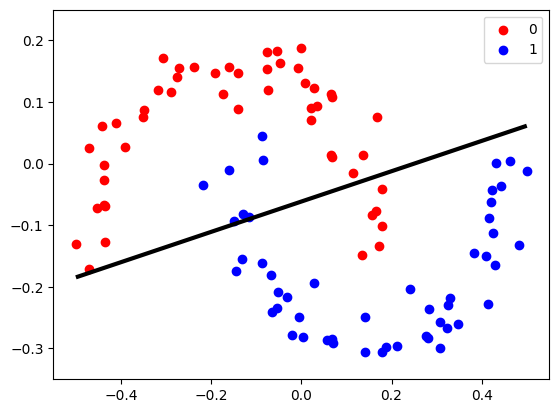

<Figure size 640x480 with 0 Axes>

In [38]:
p = np.linspace(-0.5, 0.5, 500)
x_plot, y_plot = np.meshgrid(p, p)
X_plot = np.stack((x_plot, y_plot), axis=2).reshape(-1, 2)
X_plot = torch.from_numpy(X_plot).float()
output = net(X_plot)
output = output.detach().numpy()
output = output.reshape(x_plot.shape[0], x_plot.shape[1])

plt.contour(x_plot, y_plot, output, [0.5],
                  colors=('k',),
                  linewidths=(3,))
plot(X0, X1)


### Implement your first multi-layer perceptron (MLP) for point cloud classification
Now you should notice that your logistic regression model cannot classify the point cloud correctly, and this is as expected :)  
Therefore, we now ask you to implement an MLP for the same binary classification task.

In [39]:
# These are the parameters to be used
nInput = 2
nOutput = 1
nHidden = 16
act_fn = nn.ReLU()

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nHidden, act_fn):
        super().__init__()

        # Define the network layers in order.
        # Input is 2D (nInput).
        # Output is a single value (nOutput).
        # Multiple linear layers each followed by a ReLU non-linearity (apart from the last).
        #########################################################################
        # TODO: add a two-layer MLP, inside the `nn.Sequential` call.
        # Input is 2D.
        # Output is a single value.

        # Hint: unlike logistic regression where you need only one nn.Linear layer,
        # here you will have two nn.Linear layers. After the first layer, we
        # apply a ReLU activation function. The output is then passed to another
        # linear layer. Note that you should use `nHidden` below as the hidden dimension
        # of your linear layers.
        #########################################################################
        self.model = nn.Sequential(
            nn.Linear(in_features=nInput, out_features=nHidden),
            nn.ReLU(),
            nn.Linear(in_features=nHidden, out_features=nOutput),
        )

    def forward(self, batch):
        # Process batch using the defined model.
        x = self.model(batch)
        # Final sigmoid activation to obtain a probability.
        return torch.sigmoid(x)


Run below again!

In [40]:
NUM_EPOCHS = 200

# create the network.
net = MLP(nInput, nOutput, nHidden, act_fn)

# create the optimizer.
optimizer = Adam(net.parameters(), lr=0.1)

best_accuracy = 0
for epoch_idx in range(NUM_EPOCHS):
    loss = train(net, optimizer, train_dataloader, epoch_idx)
    print('[Epoch %02d] Loss: %.4f' % (epoch_idx + 1, loss))

[Epoch 01] Loss: 7.0154
[Epoch 02] Loss: 4.4104
[Epoch 03] Loss: 4.3723
[Epoch 04] Loss: 4.3032
[Epoch 05] Loss: 3.8457
[Epoch 06] Loss: 4.0175
[Epoch 07] Loss: 3.9099
[Epoch 08] Loss: 3.7362
[Epoch 09] Loss: 3.6864
[Epoch 10] Loss: 3.6851
[Epoch 11] Loss: 3.6719
[Epoch 12] Loss: 3.6817
[Epoch 13] Loss: 4.1670
[Epoch 14] Loss: 3.8539
[Epoch 15] Loss: 4.0978
[Epoch 16] Loss: 3.2592
[Epoch 17] Loss: 3.6414
[Epoch 18] Loss: 3.1525
[Epoch 19] Loss: 3.4358
[Epoch 20] Loss: 3.1845
[Epoch 21] Loss: 3.4937
[Epoch 22] Loss: 3.6183
[Epoch 23] Loss: 3.5746
[Epoch 24] Loss: 3.2750
[Epoch 25] Loss: 3.7185
[Epoch 26] Loss: 3.1788
[Epoch 27] Loss: 3.2981
[Epoch 28] Loss: 3.3602
[Epoch 29] Loss: 3.5373
[Epoch 30] Loss: 3.5239
[Epoch 31] Loss: 3.3406
[Epoch 32] Loss: 3.2960
[Epoch 33] Loss: 4.1971
[Epoch 34] Loss: 3.2947
[Epoch 35] Loss: 3.1938
[Epoch 36] Loss: 3.2127
[Epoch 37] Loss: 3.6334
[Epoch 38] Loss: 3.3689
[Epoch 39] Loss: 3.1966
[Epoch 40] Loss: 3.2598
[Epoch 41] Loss: 3.1618
[Epoch 42] Loss:

Again plot your result. You should see that the decision boundary can clearly separate the point clouds.


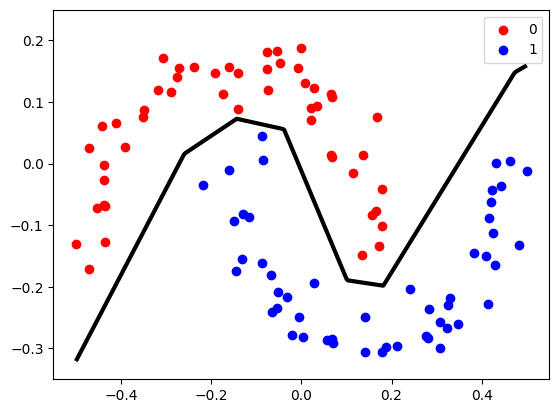

<Figure size 640x480 with 0 Axes>

In [41]:
p = np.linspace(-0.5, 0.5, 500)
x_plot, y_plot = np.meshgrid(p, p)
X_plot = np.stack((x_plot, y_plot), axis=2).reshape(-1, 2)
X_plot = torch.from_numpy(X_plot).float()
output = net(X_plot)
output = output.detach().numpy()
output = output.reshape(x_plot.shape[0], x_plot.shape[1])

plt.contour(x_plot, y_plot, output, [0.5],
                  colors=('k',),
                  linewidths=(3,))
plot(X0, X1)

When you are done, move forward to `image_classification.ipynb`.